<a href="https://colab.research.google.com/github/F1ameX/TUSUR_ML/blob/main/TUSUR_HW_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Продвинутый вариант выполнения задания

## Подготовка данных

### Подключение модулей. Загрузка датасета

Для работы с данным подключаем модули. warnings - для работы с системными предупрежденинями Python, pandas - для работы с данными.

In [2]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore') # Функция для отключения лишних предупреждений

Подгружаем датасет, необходимый для работы в этом задании.

In [3]:
df = pd.read_csv('/content/drive/MyDrive/src_5hw/preprocessed_orders_short.csv', index_col = False)
df.head()

,Unnamed: 0,store_id,order_id,profit,delivery_distance,planned_prep_time,region_id,order_price,items_count,prepared_on_time
0,0,5014.0,20562761.0,45.5040,2205.0,15.0,683.0,30.49,2.0,1.0
1,2,3856.0,20562753.0,30.3360,1368.0,10.0,683.0,240.78,2.0,1.0
2,4,10825.0,20562723.0,43.6080,459.0,20.0,683.0,85.99,1.0,1.0
3,5,8535.0,20562639.0,11.3128,1749.0,10.0,685.0,80.09,5.0,1.0
4,10,11449.0,20562617.0,4.4240,1040.0,20.0,695.0,85.99,1.0,1.0


Можно видеть, что помимо всех данных в датасет попал лишний индексирующий столбец. Его стоит удалить.

Удаляем ненужный столбец и смотрим на типы данных, пропущенные значения, структуру нашего датасета.

In [4]:
df.drop(df.columns[0], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5959 entries, 0 to 5958
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5959 non-null   int64  
 1   store_id           5959 non-null   float64
 2   order_id           5959 non-null   float64
 3   profit             5959 non-null   float64
 4   delivery_distance  5959 non-null   float64
 5   planned_prep_time  5959 non-null   float64
 6   region_id          5959 non-null   float64
 7   order_price        5959 non-null   float64
 8   items_count        5959 non-null   float64
 9   prepared_on_time   5959 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 465.7 KB


### Разделение данных

Для обучения моделей необходимо разделить данные на признаки (X) и целевую переменную (y). Также нужно разделить данные на обучающую и тестовую выборку. Это позволит проверять точность модели, возможные переобучение или недообучение.

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(['prepared_on_time'], axis = 1).copy()
y = df['prepared_on_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 52, test_size = 0.3, stratify = y)

Выполнили это. При разделении добавили stratify = y, то есть провели стратификацию по целевой переменной. Это означает, что при разбиении на выборки в каждой из выборок будут представлены экземпляры каждого класса переменной y. При этом это будет в изначальных пропорциях исходного датасета.

## Ансамбль моделей

### Подбор гиперпараметров и обучение

Установим необходимую библиотеку для подбора гиперпараметров для ансамблевых методов.

In [6]:
!pip install --quiet optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00


In [7]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score


def objective(trial):
  n_estimators = trial.suggest_int('n_estimators', 2, 100)
  max_depth = trial.suggest_int('max_depth', 2, 20)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

  base_estimator = DecisionTreeClassifier(
      max_depth = max_depth,
      min_samples_leaf = min_samples_leaf,
      class_weight = 'balanced'
  )

  ensemble = BaggingClassifier(
      estimator = base_estimator,
      n_estimators = n_estimators,
      random_state = 52
  )

  score = cross_val_score(ensemble, X_train, y_train, cv = 5, scoring = 'accuracy').mean()
  return score


study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)
trial = study.best_trial

print('Точность модели по метрике Accuracy: ', trial.value)
print('Лучшие гиперпараметры :', trial.params)

[I 2024-12-11 10:53:40,832] A new study created in memory with name: no-name-743ced66-85ec-45c5-91c6-4cc83cd5477d
[I 2024-12-11 10:53:53,997] Trial 0 finished with value: 0.5996206148853374 and parameters: {'n_estimators': 99, 'max_depth': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.5996206148853374.
[I 2024-12-11 10:54:05,709] Trial 1 finished with value: 0.7940495986444377 and parameters: {'n_estimators': 39, 'max_depth': 19, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.7940495986444377.
[I 2024-12-11 10:54:09,462] Trial 2 finished with value: 0.5725303350134263 and parameters: {'n_estimators': 79, 'max_depth': 2, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.7940495986444377.
[I 2024-12-11 10:54:12,007] Trial 3 finished with value: 0.6403785235284827 and parameters: {'n_estimators': 37, 'max_depth': 5, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.7940495986444377.
[I 2024-12-11 10:54:14,272] Trial 4 finished with value: 0.6468516205000071 and 

Точность модели по метрике Accuracy:  0.8333738278838008
Лучшие гиперпараметры : {'n_estimators': 67, 'max_depth': 19, 'min_samples_leaf': 1}


## Сравнение ансамблей

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

best_params = study.best_params

best_model = BaggingClassifier(
    estimator = DecisionTreeClassifier(
        max_depth = best_params['max_depth'],
        min_samples_leaf = best_params['min_samples_leaf'],
        class_weight = 'balanced'
    ),
    n_estimators = best_params['n_estimators'],
    random_state = 52
)

random_forest = RandomForestClassifier(
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    min_samples_leaf = best_params['min_samples_leaf'],
    class_weight = 'balanced',
    random_state = 42
)

best_model.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

best_model_pred = best_model.predict(X_test)
random_forest_pred = random_forest.predict(X_test)

print('Качество выбранной модели BaggingClassifier, ансамбль из DecisionTreeClassifier')
print(classification_report(y_test, best_model_pred))
print('Метрика Accuracy: ', accuracy_score(y_test, best_model_pred))
print('Метрика Precision: ', precision_score(y_test, best_model_pred))
print('Метрика Recall: ', recall_score(y_test, best_model_pred))
print('Метрика F1-Score: ', f1_score(y_test, best_model_pred))

print('\nКачество модели RandomForestClassifier')
print(classification_report(y_test, random_forest_pred))
print('Метрика Accuracy: ', accuracy_score(y_test, random_forest_pred))
print('Метрика Precision: ', precision_score(y_test, random_forest_pred))
print('Метрика Recall: ', recall_score(y_test, random_forest_pred))
print('Метрика F1-Score: ', f1_score(y_test, random_forest_pred))

Качество выбранной модели BaggingClassifier, ансамбль из DecisionTreeClassifier
              precision    recall  f1-score   support

         0.0       0.22      0.01      0.01       294
         1.0       0.84      1.00      0.91      1494

    accuracy                           0.83      1788
   macro avg       0.53      0.50      0.46      1788
weighted avg       0.73      0.83      0.76      1788

Метрика Accuracy:  0.8327740492170023
Метрика Precision:  0.8358628442945475
Метрика Recall:  0.9953145917001339
Метрика F1-Score:  0.9086465016804155

Качество модели RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.22      0.01      0.01       294
         1.0       0.84      1.00      0.91      1494

    accuracy                           0.83      1788
   macro avg       0.53      0.50      0.46      1788
weighted avg       0.73      0.83      0.76      1788

Метрика Accuracy:  0.8327740492170023
Метрика Precision:  0.835862844294547

## Визуализация и выводы

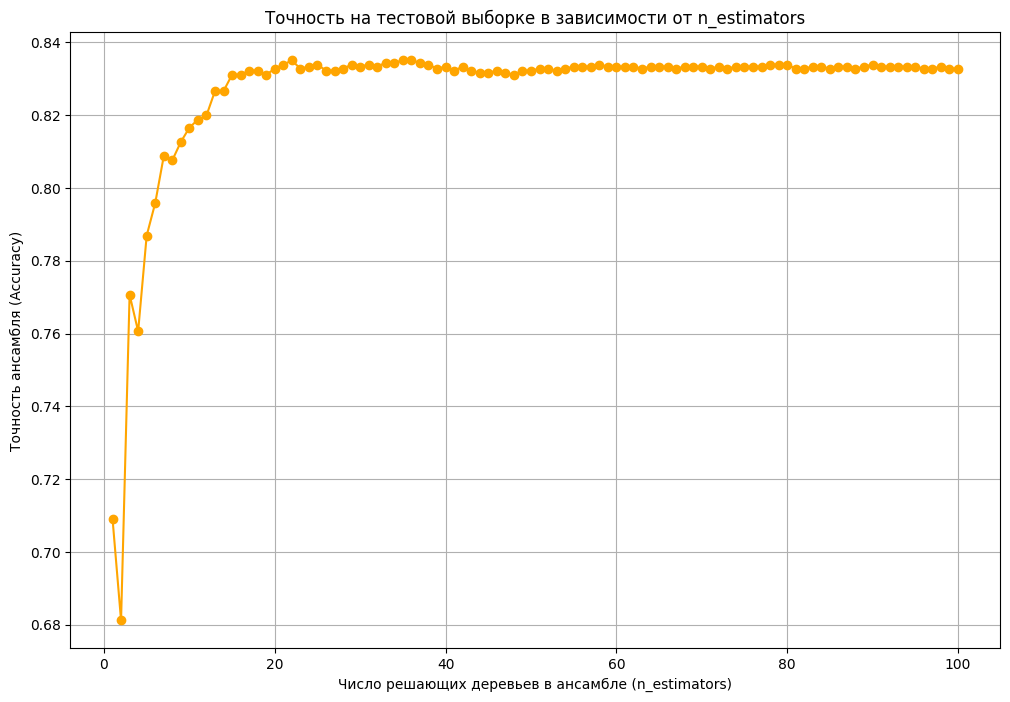

In [20]:
import matplotlib.pyplot as plt

max_depth = best_params["max_depth"]
min_samples_leaf = best_params["min_samples_leaf"]

n_estimators_range = list(range(1, 101))  # Преобразуем в список
scores = []


for n_estimators in n_estimators_range:
    model = BaggingClassifier(
        estimator=DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            class_weight="balanced"
        ),
        n_estimators=n_estimators,
        random_state=52
    )

    model.fit(X_train, y_train)

    score = model.score(X_test, y_test)
    scores.append(score)

plt.figure(figsize=(12, 8))
plt.plot(n_estimators_range, scores, marker='o', linestyle='-', label='Accuracy', color = 'orange')
plt.xlabel("Число решающих деревьев в ансамбле (n_estimators)")
plt.ylabel("Точность ансамбля (Accuracy)")
plt.title("Точность на тестовой выборке в зависимости от n_estimators")
plt.grid(True)
plt.show()